# Live Rabi

In [1]:
%matplotlib widget

In [2]:
import time
import numpy as np
from IPython.display import display
import ipywidgets as widgets
from matplotlib import pyplot as plt
from qualang_tools.units import unit
u = unit(coerce_to_integer=True)
from qm.qua import *
from qualang_tools.loops import from_array
import threading
from scipy.interpolate import make_smoothing_spline

2026-01-30 02:20:01,997 - qm - INFO     - Starting session: 85bc5a07-73ef-4d5f-92e8-d06a348007e1


In [3]:
from qm import QuantumMachinesManager
QM_Router_IP = "129.175.113.167"
cluster_name = "Cluster_1"
qmm = QuantumMachinesManager(host=QM_Router_IP, cluster_name=cluster_name, log_level="ERROR",) 

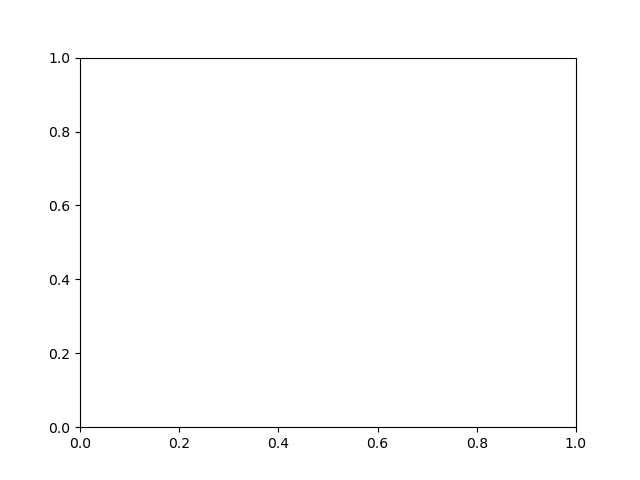

Output()

In [4]:
def rabi_factory(n_avg):
    # Pulse duration sweep (in clock cycles = 4ns) - must be larger than 4 clock cycles
    t_min = 4 // 4
    t_max = 800 // 4
    dt = 8 // 4
    durations = np.arange(t_min, t_max, dt)
    looptime = 2e-6 * n_avg * len(durations) 
    
    ###################
    # The QUA program #
    ###################
    with program() as qmprog:
        n = declare(int)  # QUA variable for the averaging loop
        t = declare(int)  # QUA variable for the qubit pulse duration
        I = declare(fixed)  # QUA variable for the measured 'I' quadrature
        Q = declare(fixed)  # QUA variable for the measured 'Q' quadrature
        Sz = declare(fixed)
        Sz_st = declare_stream()  # Stream for the state
    
        update_frequency('resonator',59980000)
        with infinite_loop_():  # QUA for_ loop for averaging
            with for_(*from_array(t, durations)):  # QUA for_ loop for sweeping the pulse duration
                update_frequency('qubit',IO2)
                # Play the qubit pulse with a variable duration (in clock cycles = 4ns)
                play("pi"*amp(IO1), "qubit", duration=t)
                # Align the two elements to measure after playing the qubit pulse.
                align("qubit", "resonator")
                # Measure the state of the resonator
                measure(
                    "readout",
                    "resonator",
                    dual_demod.full("cos", "sin", I),
                    dual_demod.full("minus_sin", "cos", Q),
                )
                # Send back qubit to ground state
                assign(Sz, Util.cond(Q>2e-4, -0.5, 0.5))
                with if_(Q>2e-4):
                    update_frequency('qubit',50000000)
                    play("pi", "qubit", duration=100*u.ns)
                save(Sz, Sz_st)
    
        with stream_processing():
            # Cast the data into a 1D vector, average the 1D vectors together and store the results on the OPX processor
            Sz_st.buffer(len(durations)).buffer(n_avg).map(FUNCTIONS.average(0)).save("Sz")
        
    return qmprog, looptime, durations

class ProgressPlot:
    """
    Real time plot to monitor a QM job
    """
    def __init__(self):
        self.button_run = widgets.Button(description='Run',)
        self.button_stop = widgets.Button(description='Stop',)
        self.button_run.on_click(self.run_clicked)
        self.button_stop.on_click(self.stop_clicked)
        self.slider_navg = widgets.IntSlider(value=100,min=1,max=1000,step=10,description='Averages:')
        self.slider_amplitude = widgets.FloatSlider(value=1.0,min=0,max=1.9,step=0.1,description='Amplitude:')
        self.slider_detuning = widgets.IntSlider(value=0,min=-10,max=10,description='Detuning:')
        self.slider_amplitude.observe(self.on_amplitude_change, names='value')
        self.slider_detuning.observe(self.on_detuning_change, names='value')
        self.abort = False
        self.output= widgets.Output()
        with plt.ioff():
            self.fig = plt.figure()
        self.ax = self.fig.subplots()
        self.show()

    def run_clicked(self,button):
        try:
            qm_list = qmm.list_open_qms()
            self.qm = qmm.get_qm(qm_list[0])
        except:
            self.output.append_stdout(f"{'Could not connect to QM':40s}\r")
            raise
        qmprog, looptime, durations = rabi_factory(self.slider_navg.value)
        self.looptime = looptime
        self.time_axis = 4*durations
        self.job = self.qm.queue.add(qmprog)
        self.plot_init()
        self.thread = threading.Thread(target=self.run)
        self.abort = False
        self.button_run.disabled = True
        self.slider_navg.disabled = True
        self.thread.start()
        
    def plot_init(self):
        self.ax.cla()
        l_Sz, = self.ax.plot(self.time_axis, np.nan*np.zeros_like(self.time_axis), 'r.')
        l_Sz_spline, = self.ax.plot(self.time_axis, np.nan*np.zeros_like(self.time_axis), 'k', alpha=0.7)        
        self.ax.set_ylim(-0.5,0.5)
        self.ax.set_xlim(self.time_axis[0], self.time_axis[-1])
        self.lines = l_Sz, l_Sz_spline
    
    def plot_update(self):
        l_Sz, l_Sz_spline = self.lines
        if self.handle.count_so_far() >= 1:
            Sz = self.handle.fetch(0)
            l_Sz.set_ydata(Sz)  
            spl = make_smoothing_spline(self.time_axis, Sz, lam=500)
            l_Sz_spline.set_ydata(spl(self.time_axis))

    def show(self):
        display(self.fig.canvas,
                widgets.HBox([self.button_run, self.button_stop,self.slider_navg]),
                widgets.HBox([self.slider_amplitude,self.slider_detuning,widgets.Label('MHz')]),
                self.output)
        
    def stop_clicked(self, button):
        self.abort = True
        self.thread.join()
        self.button_run.disabled = False
        self.slider_navg.disabled = False

    def on_amplitude_change(self,change):
        self.qm.set_io1_value(change['new'])

    def on_detuning_change(self,change):
        self.qm.set_io2_value(50000000 + 1000000*change['new'])
        
    def run(self):
        self.output.append_stdout(f"{'Job loaded':40s}\r")
        while self.job.status=="pending" or self.job.status=="loading":
            time.sleep(1)
            self.output.append_stdout(f"{'Job queing':40s}\r")
            if self.abort:
                self.job.cancel()
                self.output.append_stdout(f"{'Job canceled':40s}\r")
                return
        self.qm.set_io_values(self.slider_amplitude.value, 50000000+ 1000000*self.slider_detuning.value)
        self.job = self.job.wait_for_execution()
        self.handle = self.job.result_handles.get('Sz')
        self.output.append_stdout(f"{'Job running':40s}\r")
        while self.job.status=="running":
            time.sleep(self.looptime)
            self.plot_update()
            self.fig.canvas.draw_idle()
            if self.abort:
                self.job.halt()
                break
        self.output.append_stdout(f"{'Job finished':40s}\r")

    def __del__(self):
        self.abort = True
        try:
            self.thread.join()
        except:
            pass
        try:
            self.job.cancel()
        except:
            pass
        try:
            self.job.halt()
        except:
            passs
                
pp = ProgressPlot()